<a href="https://colab.research.google.com/github/runnin123/Jeju_Bigdata/blob/master/Jeju_bigdata_lcl_trst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 시각화
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt  # Matlab-style plotting

# 통계
from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd

In [4]:
project_id = 'jeju-bigquery-282708'
client = bigquery.Client(project=project_id)

train = client.query('''
  SELECT 
      * 
  FROM `jeju-bigquery-282708.jeju_bigdata.201901_202003_train` 
  WHERE RAND() < 100000 / (SELECT COUNT(*) FROM `jeju-bigquery-282708.jeju_bigdata.201901_202003_train`)
  ''').to_dataframe()

In [5]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [6]:
# 날짜 처리
data = train.copy()
data = data.fillna('')
data['REG_YYMM'].head()

0    201901
1    201901
2    201903
3    201902
4    201904
Name: REG_YYMM, dtype: int64

In [7]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)
data.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,강원,강릉시,피자 햄버거 샌드위치 및 유사 음식점업,강원,강릉시,10s,1,1,59,666700,107,2019,1
1,서울,강북구,한식 음식점업,강원,강릉시,20s,2,1,6,112300,7,2019,1
2,강원,강릉시,피자 햄버거 샌드위치 및 유사 음식점업,강원,강릉시,20s,1,2,146,2128810,205,2019,3
3,울산,남구,피자 햄버거 샌드위치 및 유사 음식점업,강원,원주시,20s,1,1,3,31900,3,2019,2
4,강원,고성군,비알콜 음료점업,강원,고성군,20s,2,1,15,138840,22,2019,4


In [8]:
local = data[data['CARD_CCG_NM']==data['HOM_CCG_NM']].reset_index(drop=True)
tourist = data[data['CARD_CCG_NM']!=data['HOM_CCG_NM']].reset_index(drop=True)

In [9]:
# 데이터 정제
local = local.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
local = local.groupby(columns).sum().reset_index(drop=False)

In [10]:
# 데이터 정제
tourist = tourist.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
tourist = tourist.groupby(columns).sum().reset_index(drop=False)

In [11]:
# 인코딩
dtypes_lcl = local.dtypes
encoders = {}
for column in local.columns:
    if str(dtypes_lcl[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(local[column])
        encoders[column] = encoder
        
lcl_num = local.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    lcl_num[column] = encoder.transform(local[column])

In [12]:
# 인코딩
dtypes_trst = tourist.dtypes
encoders = {}
for column in tourist.columns:
    if str(dtypes_lcl[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(tourist[column])
        encoders[column] = encoder
        
trst_num = tourist.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    trst_num[column] = encoder.transform(tourist[column])

In [13]:
from sklearn.model_selection import train_test_split

X_lcl, y_lcl = lcl_num.loc[:, lcl_num.columns != 'AMT'], lcl_num['AMT']
X_lcl  = X_lcl.drop(['CSTMR_CNT', 'CNT'], axis=1)
X_train_lcl, X_test_lcl, y_train_lcl, y_test_lcl = train_test_split(X_lcl, y_lcl, test_size=0.3, random_state=126, shuffle=True)
X_train_lcl.shape, y_train_lcl.shape, X_test_lcl.shape, y_test_lcl.shape

((4999, 8), (4999,), (2143, 8), (2143,))

In [14]:
X_trst, y_trst = trst_num.loc[:, trst_num.columns != 'AMT'], trst_num['AMT']
X_trst = X_trst.drop(['CSTMR_CNT', 'CNT'], axis=1)
X_train_trst, X_test_trst, y_train_trst, y_test_trst = train_test_split(X_trst, y_trst, test_size=0.3, random_state=126, shuffle=True)
X_train_trst.shape, y_train_trst.shape, X_test_trst.shape, y_test_trst.shape

((47692, 8), (47692,), (20440, 8), (20440,))

In [15]:
y_train_lcl, y_train_trst = np.log1p(y_train_lcl), np.log1p(y_train_trst)


 mu = 14.68 and sigma = 2.07



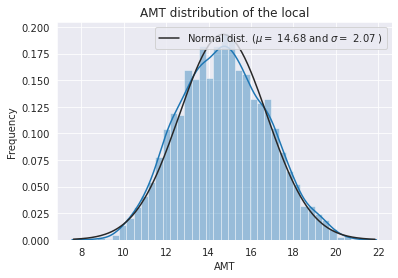

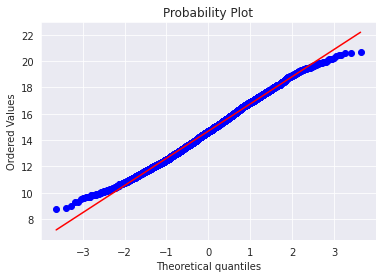

In [16]:
sns.distplot(y_train_lcl, fit=norm);
(mu, sigma) = norm.fit(y_train_lcl)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution of the local')

fig = plt.figure()
res = stats.probplot(y_train_lcl, plot=plt)
plt.show()


 mu = 12.64 and sigma = 1.66



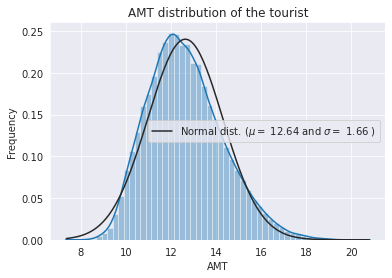

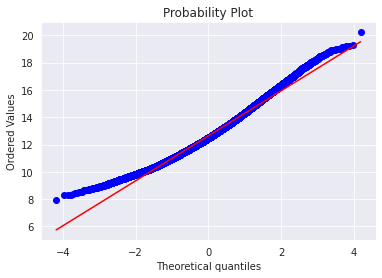

In [17]:
sns.distplot(y_train_trst, fit=norm);
(mu, sigma) = norm.fit(y_train_trst)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution of the tourist')

fig = plt.figure()
res = stats.probplot(y_train_trst, plot=plt)
plt.show()

In [18]:
def rmsle(y, pred): 
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return print('Test Data RMSLE: {0:.3f}'.format(rmsle))

In [19]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [20]:
# 교차검증 수행
def lcl_best_params_model(model, params):
  cv_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv = 5)
  cv_model.fit(X_train_lcl, y_train_lcl)
  print("----", model.__class__.__name__, "----")
  print("GridSearchCV 최적 하이퍼 파라미터 :", cv_model.best_params_)

  rmse = np.sqrt(-1*cv_model.best_score_)
  print("GridSearchCV 최적 평균 RMSE값 :", np.round(rmse, 3))

  eval_pred = cv_model.predict(X_test_lcl)
  eval_pred = np.expm1(eval_pred)
  rmsle(y_test_lcl, eval_pred)
  
  return cv_model.best_estimator_

In [21]:
# 교차검증 수행
def trst_best_params_model(model, params):
  cv_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv = 5)
  cv_model.fit(X_train_trst, y_train_trst)
  print("----", model.__class__.__name__, "----")
  print("GridSearchCV 최적 하이퍼 파라미터 :", cv_model.best_params_)

  rmse = np.sqrt(-1*cv_model.best_score_)
  print("GridSearchCV 최적 평균 RMSE값 :", np.round(rmse, 3))

  eval_pred = cv_model.predict(X_test_trst)
  eval_pred = np.expm1(eval_pred)
  rmsle(y_test_trst, eval_pred)
  
  return cv_model.best_estimator_

In [22]:
from sklearn.linear_model import LinearRegression

# 4개의 모델 선언
# random_state = 0 <- 이 숫자는 아무거나 적어도 상관 X
# xgb gbm lgb 모두 'random_state=0' <- 모두 같은 데이터로 모델링
xgb = XGBRegressor(random_state=0)
gbm = GradientBoostingRegressor(random_state=0)
lgb = LGBMRegressor(random_state=0)  

params = {'n_estimators': [1000, 2000]}

models = [xgb, gbm, lgb] # 모형 하나 추가 함
best_models_lcl = []
for model in models:
  new_model = lcl_best_params_model(model=model, params=params)
  best_models_lcl.append(new_model)

[04:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:43:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:43:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:43:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:44:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [23]:
from sklearn.linear_model import LinearRegression

# 4개의 모델 선언
# random_state = 0 <- 이 숫자는 아무거나 적어도 상관 X
# xgb gbm lgb 모두 'random_state=0' <- 모두 같은 데이터로 모델링
xgb = XGBRegressor(random_state=0)
gbm = GradientBoostingRegressor(random_state=0)
lgb = LGBMRegressor(random_state=0)  

params = {'n_estimators': [1000, 2000]}

models = [xgb, gbm, lgb] # 모형 하나 추가 함
best_models_trst = []
for model in models:
  new_model = trst_best_params_model(model=model, params=params)
  best_models_trst.append(new_model)

[04:44:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:45:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:45:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:45:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:45:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:45:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [24]:
# lcl 모형 불러오기
xgb_reg_lcl = best_models_lcl[0]
gbm_reg_lcl = best_models_lcl[1]
lgb_reg_lcl = best_models_lcl[2]

# 예측 데이터 세트
xgb_pred_lcl = xgb_reg_lcl.predict(X_test_lcl)
xgb_pred_lcl = np.expm1(xgb_pred_lcl)

gbm_pred_lcl = gbm_reg_lcl.predict(X_test_lcl)
gbm_pred_lcl = np.expm1(gbm_pred_lcl)

lgb_pred_lcl = lgb_reg_lcl.predict(X_test_lcl)
lgb_pred_lcl = np.expm1(lgb_pred_lcl)

pred_lcl = np.array([xgb_pred_lcl, gbm_pred_lcl, lgb_pred_lcl])
print(pred_lcl.shape)

# transpose를 이용해 행과 열의 위치 교환
pred_lcl = np.transpose(pred_lcl)
print(pred_lcl.shape)

(3, 2143)
(2143, 3)


In [51]:
final_lcl = xgb_pred_lcl*0.60 + gbm_pred_lcl*0.20 + lgb_pred_lcl*0.20
rmsle(y_test_lcl, final_lcl)

Test Data RMSLE: 1.309


In [39]:
# trst 모형 불러오기
xgb_reg_trst = best_models_trst[0]
gbm_reg_trst = best_models_trst[1]
lgb_reg_trst = best_models_trst[2]

# 예측 데이터 세트
xgb_pred_trst = xgb_reg_trst.predict(X_test_trst)
xgb_pred_trst = np.expm1(xgb_pred_trst)

gbm_pred_trst = gbm_reg_trst.predict(X_test_trst)
gbm_pred_trst = np.expm1(gbm_pred_trst)

lgb_pred_trst = lgb_reg_trst.predict(X_test_trst)
lgb_pred_trst = np.expm1(lgb_pred_trst)

pred_trst = np.array([xgb_pred_trst, gbm_pred_trst, lgb_pred_trst])
print(pred_trst.shape)

# transpose를 이용해 행과 열의 위치 교환
pred_trst = np.transpose(pred_trst)
print(pred_trst.shape)

(3, 20440)
(20440, 3)


In [44]:
final_trst = xgb_pred_trst*0.30 + gbm_pred_trst*0.20 + lgb_pred_trst*0.50
rmsle(y_test_trst, final_trst)

Test Data RMSLE: 1.255


In [52]:
from itertools import product

# lcl 예측 템플릿 만들기
CARD_SIDO_NMs = lcl_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = lcl_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = lcl_num['HOM_SIDO_NM'].unique()
AGEs          = lcl_num['AGE'].unique()
SEX_CTGO_CDs  = lcl_num['SEX_CTGO_CD'].unique()
FLCs          = lcl_num['FLC'].unique()
years         = [2020]
months        = [4, 7]

comb_list = [CARD_SIDO_NMs, STD_CLSS_NMs,HOM_SIDO_NMs, AGEs, SEX_CTGO_CDs, FLCs, years, months]
temp = np.array(list(product(*comb_list)))

train_features = lcl_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
temp_lcl = pd.DataFrame(data=temp, columns=train_features.columns)

In [53]:
# lcl 예측 데이터 세트
xgb_pred_lcl = xgb_reg_lcl.predict(temp_lcl)
xgb_pred_lcl = np.expm1(xgb_pred_lcl)

gbm_pred_lcl = gbm_reg_lcl.predict(temp_lcl)
gbm_pred_lcl = np.expm1(gbm_pred_lcl)

lgb_pred_lcl = lgb_reg_lcl.predict(temp_lcl)
lgb_pred_lcl = np.expm1(lgb_pred_lcl)

In [55]:
final_lcl = xgb_pred_lcl*0.60 + gbm_pred_lcl*0.20 + lgb_pred_lcl*0.20

temp_lcl['AMT'] = np.round(final_lcl, 0)
temp_lcl['REG_YYMM'] = temp_lcl['year']*100 + temp_lcl['month']
temp_lcl = temp_lcl[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp_lcl = temp_lcl.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [56]:
# 디코딩 
temp_lcl['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp_lcl['CARD_SIDO_NM'])
temp_lcl['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp_lcl['STD_CLSS_NM'])

temp_lcl.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,148372004.0
1,202004,강원,골프장 운영업,214317081.0
2,202004,강원,과실 및 채소 소매업,170860276.0
3,202004,강원,관광 민예품 및 선물용품 소매업,7739481.0
4,202004,강원,그외 기타 스포츠시설 운영업,9573331.0


In [57]:
from itertools import product

# trst 예측 템플릿 만들기
CARD_SIDO_NMs = trst_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = trst_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = trst_num['HOM_SIDO_NM'].unique()
AGEs          = trst_num['AGE'].unique()
SEX_CTGO_CDs  = trst_num['SEX_CTGO_CD'].unique()
FLCs          = trst_num['FLC'].unique()
years         = [2020]
months        = [4, 7]

comb_list = [CARD_SIDO_NMs, STD_CLSS_NMs,HOM_SIDO_NMs, AGEs, SEX_CTGO_CDs, FLCs, years, months]
temp = np.array(list(product(*comb_list)))

train_features = lcl_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
temp_trst = pd.DataFrame(data=temp, columns=train_features.columns)

In [58]:
# trst 예측 데이터 세트
xgb_pred_trst = xgb_reg_trst.predict(temp_trst)
xgb_pred_trst = np.expm1(xgb_pred_trst)

gbm_pred_trst = gbm_reg_trst.predict(temp_trst)
gbm_pred_trst = np.expm1(gbm_pred_trst)

lgb_pred_trst = lgb_reg_trst.predict(temp_trst)
lgb_pred_trst = np.expm1(lgb_pred_trst)

In [59]:
final_trst = xgb_pred_trst*0.30 + gbm_pred_trst*0.20 + lgb_pred_trst*0.50

temp_trst['AMT'] = np.round(final_trst, 0)
temp_trst['REG_YYMM'] = temp_trst['year']*100 + temp_trst['month']
temp_trst = temp_trst[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp_trst = temp_trst.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [61]:
# 디코딩 
temp_trst['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp_trst['CARD_SIDO_NM'])
temp_trst['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp_trst['STD_CLSS_NM'])

temp_trst.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,60755538.0
1,202004,강원,골프장 운영업,200059455.0
2,202004,강원,과실 및 채소 소매업,45172959.0
3,202004,강원,관광 민예품 및 선물용품 소매업,23066033.0
4,202004,강원,그외 기타 스포츠시설 운영업,20624665.0


In [ ]:
temp_lcl.head(50)

In [ ]:
temp_trst.head(50)

In [62]:
sub = temp_lcl[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']]

sub.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM
0,202004,강원,건강보조식품 소매업
1,202004,강원,골프장 운영업
2,202004,강원,과실 및 채소 소매업
3,202004,강원,관광 민예품 및 선물용품 소매업
4,202004,강원,그외 기타 스포츠시설 운영업


In [67]:
temp_lcl.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,148372004.0
1,202004,강원,골프장 운영업,214317081.0
2,202004,강원,과실 및 채소 소매업,170860276.0
3,202004,강원,관광 민예품 및 선물용품 소매업,7739481.0
4,202004,강원,그외 기타 스포츠시설 운영업,9573331.0


In [69]:
temp_trst.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,60755538.0
1,202004,강원,골프장 운영업,200059455.0
2,202004,강원,과실 및 채소 소매업,45172959.0
3,202004,강원,관광 민예품 및 선물용품 소매업,23066033.0
4,202004,강원,그외 기타 스포츠시설 운영업,20624665.0


In [63]:
sub['AMT'] = temp_lcl['AMT'] + temp_trst['AMT']

sub

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,2.091275e+08
1,202004,강원,골프장 운영업,4.143765e+08
2,202004,강원,과실 및 채소 소매업,2.160332e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,3.080551e+07
4,202004,강원,그외 기타 스포츠시설 운영업,3.019800e+07
...,...,...,...,...
1355,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,7.890357e+08
1356,202007,충북,한식 음식점업,7.970505e+09
1357,202007,충북,호텔업,3.685792e+08
1358,202007,충북,화장품 및 방향제 소매업,5.244824e+08


In [70]:
# Submission 파일 작업 및 내보내기
submission = client.query('''
  SELECT 
    * 
  FROM `jeju-bigquery-282708.jeju_bigdata.submission` 
  ''').to_dataframe()

In [71]:
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(sub, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission['AMT'] = submission['AMT'].fillna(0)

submission.head()

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,209127542.0
1,1,202004,강원,골프장 운영업,414376536.0
2,2,202004,강원,과실 및 채소 소매업,216033235.0
3,3,202004,강원,관광 민예품 및 선물용품 소매업,30805514.0
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.0


In [73]:
temp_lcl.head(50)

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,1.483720e+08
1,202004,강원,골프장 운영업,2.143171e+08
2,202004,강원,과실 및 채소 소매업,1.708603e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,7.739481e+06
4,202004,강원,그외 기타 스포츠시설 운영업,9.573331e+06
5,202004,강원,그외 기타 종합 소매업,1.019621e+08
6,202004,강원,기타 대형 종합 소매업,7.958741e+08
7,202004,강원,기타 수상오락 서비스업,2.377913e+07
8,202004,강원,기타 외국식 음식점업,3.044751e+08
9,202004,강원,기타 주점업,1.589767e+08


In [76]:
submission.head()

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,209127542.0
1,1,202004,강원,골프장 운영업,414376536.0
2,2,202004,강원,과실 및 채소 소매업,216033235.0
3,3,202004,강원,관광 민예품 및 선물용품 소매업,30805514.0
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.0


In [77]:
submission.to_csv('/content/drive/My Drive/Colab Notebooks/jeju/submission10.csv', encoding='utf-8-sig', index=False)